In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np
import datetime
import re
import time

In [92]:
log_path = "logs/SCHED_"
algos = ["RR", "RANDOM", "LL"]

In [93]:
log_file = log_path + algos[0]

In [94]:
master_log = log_file + "/master.log"
worker_1_log = log_file + "/worker_1.log"
worker_2_log = log_file + "/worker_2.log"
worker_3_log = log_file + "/worker_3.log"

In [95]:
# Parsing jobs
job_arrival_pattern = r"\[(.*)\] Job arrived: (.*)"
job_ending_pattern = r"\[(.*)\] Completed job: (.*)"

# Parsing tasks
task_arrival_pattern = r"\[(.*)\] Task arrived: (.*)"
task_ending_pattern = r"\[(.*)\] Completed task: (.*)"

In [96]:
def duration(start, end):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")
    
    duration = end - start
    
    elapsed = float((duration.days * 86400) + (duration.seconds * 1) + float(duration.microseconds / 1000) / 1000)
    
    return elapsed

In [97]:
f = open(master_log, "r")
lines = f.readlines()
f.close()

In [98]:
def compute_stats(lines, arrival_pattern, ending_pattern):
    times = dict()
    for line in lines:
        start = re.match(arrival_pattern, line)
        if start:
            timestamp, Id = start.groups()
            times[Id] = timestamp
            continue

        end = re.search(ending_pattern, line)
        if end:
            end_timestamp, Id = end.groups()
            start_timestamp = times[Id]

            time_duration = duration(start_timestamp, end_timestamp)

            times[Id] = time_duration
    times = pd.DataFrame(times.values(), columns=["durations"])
    mean = times["durations"].mean()
    median = times["durations"].median()
    
    return mean, median

In [99]:
job_mean, job_median = compute_stats(lines, job_arrival_pattern, job_ending_pattern)
print(job_mean, job_median)

9.111984200000002 9.023033


In [100]:
f = open(worker_1_log, "r")
lines1 = f.readlines()
f.close()

f = open(worker_2_log, "r")
lines2 = f.readlines()
f.close()

f = open(worker_3_log, "r")
lines3 = f.readlines()
f.close()


lines = lines1 + lines2 + lines3

In [101]:
task_mean, task_median = compute_stats(lines, task_arrival_pattern, task_ending_pattern)
print(task_mean, task_median)

3.672070733333333 4.0031285


In [102]:
f = open(master_log, "r")
base_line = f.readline()
f.close()

base_match = re.match(job_arrival_pattern, base_line)
if base_match:
    base, _ = base_match.groups()

In [103]:
f = open(worker_1_log, "r")
lines = f.readlines()
f.close()

In [162]:
def get_plot_vals(lines, task_arrival_pattern, task_ending_pattern, base):
    stats = []
    for line in lines:
        start_match = re.match(task_arrival_pattern, line)
        if start_match:
            start_time, _ = start_match.groups()
            diff = duration(base, start_time)
            stats.append([diff, 1])
            continue

        end_match = re.match(task_ending_pattern, line)
        if end_match:
            end_time, _ = end_match.groups()
            diff = duration(base, end_time)
            stats.append([diff, -1])
            continue

    x = [i[0] for i in stats]
    y = [i[1] for i in stats]
    y = [sum(y[:i]) for i in range(1, len(y)+1)]
    return x, y

In [163]:
x, y = get_plot_vals(lines, task_arrival_pattern, task_ending_pattern, base)
plt.figure(figsize=(15, 10))
plt.scatter(x, y)
plt.show()

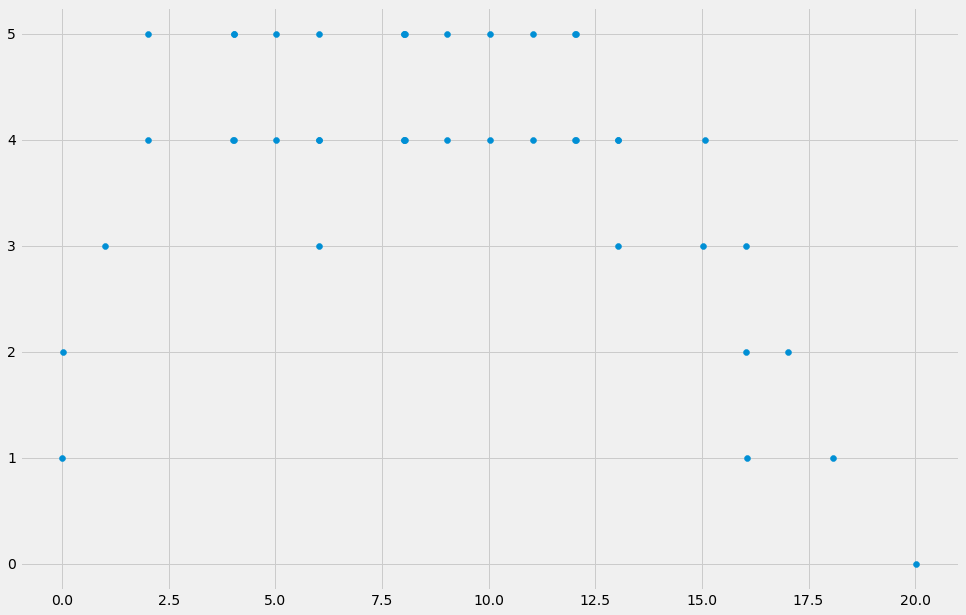

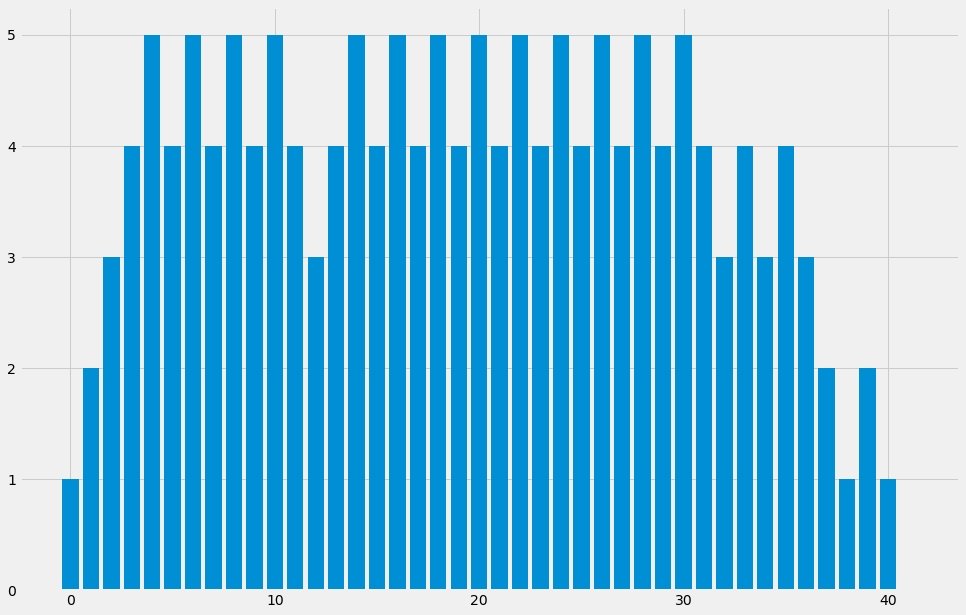

In [170]:
x_bar = [i for i in range(len(x))]
y_bar = y

plt.figure(figsize=(15, 10))
plt.bar(x_bar, y_bar)
plt.show()

In [165]:
x

[0.006025,
 0.027184,
 1.010158,
 2.015349,
 2.015608,
 4.01938,
 4.020738,
 4.033114,
 4.034016,
 5.013574,
 5.014204,
 6.019104,
 6.019201,
 6.020321,
 6.020561,
 8.017281,
 8.018179,
 8.025393,
 8.026288,
 8.038072,
 8.039101,
 9.023264,
 9.02495,
 10.024612,
 10.025677,
 11.029736,
 11.030567,
 12.020622,
 12.021613,
 12.043217,
 12.044243,
 13.028076,
 13.028303,
 13.029136,
 15.034585,
 15.065557,
 16.024505,
 16.032273,
 16.047374,
 17.026682,
 18.067376,
 20.029495]